<a href="https://colab.research.google.com/github/oduolaidrisA/Scientific-Machine-Learning/blob/main/Energy_dissipative_DeepONet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=4378c32bb1a9859d07773dc6ef98f36db5999f6ed05e35bae8f8edf4bea6bbf9
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [2]:
import os

#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import linalg as LA
import torch.nn as nn
from torch.autograd import grad
from pathlib import Path
from pyDOE import lhs
import torch.optim as optim
from torch.nn.utils import parameters_to_vector, vector_to_parameters #Converts parameters to a vector and vice-versa
from torch.func import functional_call #Allows temporary swapping of new parameters/buffers in a module
from collections import OrderedDict   #To preserve ordering of dictionary keys
from torch.autograd.functional import jacobian #To compute jacobians

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [3]:
class config:
  def __init__(self):
    #The training parameters
    self.num_epoch = 10000

    #Optimizer
    self.lr = 0.001

    #Dataset parameters
    self.a_grid = 1 + (2-1)*torch.tensor(lhs(1,70))
    self.x_grid =  torch.linspace(0,2, 50).view(-1,1).float()

    ##Model hyperparameters
    self.tb_dim = 20 #Trunk and branch output dimension
    self.hidden_layers = 30 #Hidden layers for trunk and branch

    #self.model_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/deeponet_burgers_model.pt'
    #self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_burgers_deeponet'


cfg = config()

In [4]:
#Generating the dataset
#generating random values for a in [1,2]

print(f"a is of shape: {cfg.a_grid.shape}")

#The trunk input

print(f"x is of shape: {cfg.x_grid.shape}")

def init_cond(a_in,x):
    #a_in: (n_a, 1); x: (n_x,1); a_in.unsqueeze(1): (n_a, 1, 1);  torch.sin(torch.pi * x).unsqueeze(0): (1,n_x, 1)
    out = a_in.unsqueeze(1) * torch.sin(torch.pi * x).unsqueeze(0) # (n_a,n_x,1)
    return out.squeeze(2)

u0 = init_cond(cfg.a_grid,cfg.x_grid)
print(f"Initial Condition is of shape: {u0.shape}")

a is of shape: torch.Size([70, 1])
x is of shape: torch.Size([50, 1])
Initial Condition is of shape: torch.Size([70, 50])


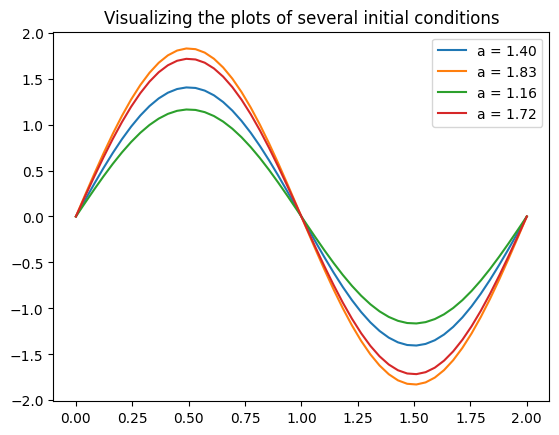

In [5]:
#Visualizing
plt.plot(cfg.x_grid.squeeze(1), u0[0], label = f"a = {cfg.a_grid[0].item():.2f}")
plt.plot(cfg.x_grid.squeeze(1), u0[10], label = f"a = {cfg.a_grid[10].item():.2f}")
plt.plot(cfg.x_grid.squeeze(1), u0[20], label = f"a = {cfg.a_grid[20].item():.2f}")
plt.plot(cfg.x_grid.squeeze(1), u0[30], label = f"a = {cfg.a_grid[30].item():.2f}")
plt.title("Visualizing the plots of several initial conditions")
plt.legend()
plt.show()

In [6]:
#first we define our NN module for
class NN(nn.Module):
    def __init__(self, cfg, layers , branch = True):
        super().__init__()
        self.activation = nn.Tanh()
        self.tb_dim = cfg.tb_dim
        self.hidden_dim = cfg.hidden_layers
        self.branch_input = 1
        self.layers = layers #The number of layers

        #Defining the linear layers
        self.linears = nn.ModuleList()

        if branch:
            self.linears.append(nn.Linear(self.branch_input, self.hidden_dim)) #The first layer for the branch net
        else:
            self.linears.append(nn.Linear(1, self.hidden_dim)) #The first layer for the trunk net
        #Other layers
        for _ in range(self.layers - 2):
            self.linears.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        self.linears.append(nn.Linear(self.hidden_dim, self.tb_dim)) #Output is (1024,tb_dim)

    def forward(self,x):
        a = x.float()
        for linear in self.linears[:-1]:
            a = self.activation(linear(a))
        return self.linears[-1](a)

In [7]:
class DeepONet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.branch = NN(cfg, layers= 3, branch= True) #branch net
        self.trunk = NN(cfg, layers= 2, branch= False) #trunk net
        self.cfg = cfg

    def forward(self,x,t):
        """
        a: shape (batch, 1)
        t: shape (50,1)

        output: (batch, 50)
        """

        #The branch net: (batch, 1) --> (batch, tb_dim)
        B_out = self.branch(x)

        #The Trunk net: (50,1) --> (50,tb_dim)
        T_out = self.trunk(t)

        #The inner product
        G = B_out @ T_out.T    #(batch, 50)

        return G

In [8]:
model = DeepONet(cfg)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(),lr = 1e-3)

DeepONet(
  (branch): NN(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=30, bias=True)
      (1): Linear(in_features=30, out_features=30, bias=True)
      (2): Linear(in_features=30, out_features=20, bias=True)
    )
  )
  (trunk): NN(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=30, bias=True)
      (1): Linear(in_features=30, out_features=20, bias=True)
    )
  )
)


In [9]:
a_grid = cfg.a_grid.to(device); x_grid = cfg.x_grid.to(device); u0 = u0.to(device)
Loss = nn.MSELoss()
metric = {'loss':[]}
for iter in range(cfg.num_epoch + 1):
    optimizer.zero_grad()

    u_hat = model(a_grid,x_grid)
    assert u_hat.shape == u0.shape, f"Shape Mismatch! prediction shape:{u_hat.shape}, target shape: {u0.shape}"
    loss = Loss(u0.float(), u_hat.float())
    metric['loss'].append(loss.item)

    if iter %(cfg.num_epoch //10) == 0:
        print(f"Epoch: {iter} ---- loss: {loss.item()}")

    loss.backward()
    optimizer.step()

Epoch: 0 ---- loss: 1.6458714008331299
Epoch: 1000 ---- loss: 0.007916535250842571
Epoch: 2000 ---- loss: 0.0017053337069228292
Epoch: 3000 ---- loss: 0.0009752408950589597
Epoch: 4000 ---- loss: 0.0006987557862885296
Epoch: 5000 ---- loss: 0.0005210537929087877
Epoch: 6000 ---- loss: 0.0003992179990746081
Epoch: 7000 ---- loss: 0.00030522680026479065
Epoch: 8000 ---- loss: 0.00024045316968113184
Epoch: 9000 ---- loss: 0.0001914168387884274
Epoch: 10000 ---- loss: 0.00016671944467816502


### Evaluation

In [10]:
#Generating the dataset
#generating random values for a in [1,2]
batch  = 40 #grid_test = 70  #Shifting for testing
a_test1 = 1 + (2-1)*torch.tensor(lhs(1,batch)) #Shifting the test set
print(f"Shape of testing data for a: {a_test1.shape}")

u0_test = init_cond(a_test1,cfg.x_grid)
print(f"Shape of testing data for u0: {u0_test.shape}")

Shape of testing data for a: torch.Size([40, 1])
Shape of testing data for u0: torch.Size([40, 50])


In [11]:
model.eval()

u_hat_test = model(a_test1.to(device), cfg.x_grid.to(device)).detach().cpu()
print(f"Shape of prediction1: {u_hat_test.shape}")

err = ((u_hat_test - u0_test)**2).mean()
print(f"MSE is: {err}")

Shape of prediction1: torch.Size([40, 50])
MSE is: 0.00016452204434230642


<ipython-input-12-c897c1e86046>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()
<ipython-input-12-c897c1e86046>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


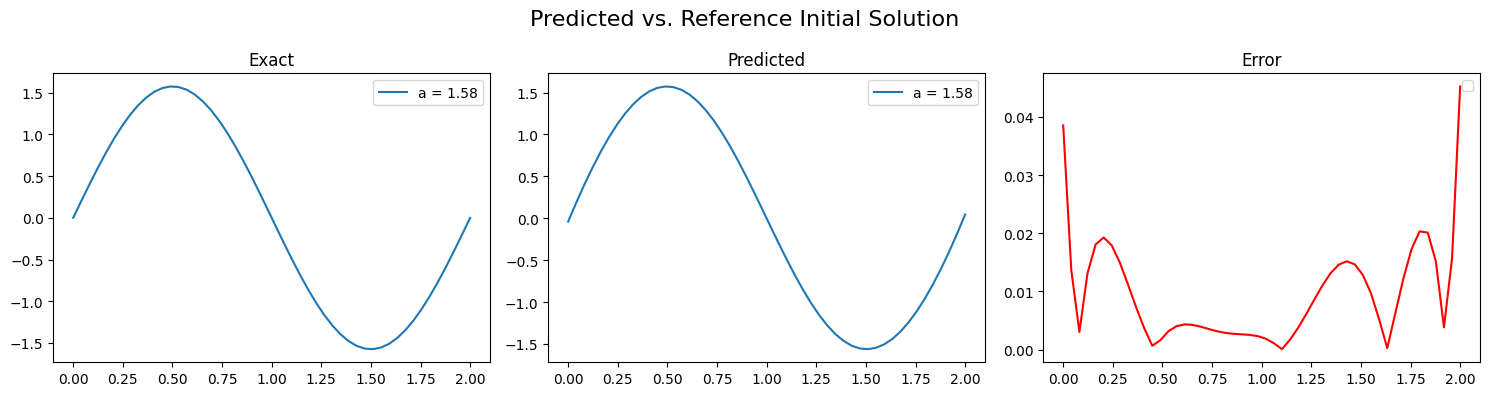

In [12]:
x_grid = cfg.x_grid.squeeze(1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Predicted vs. Reference Initial Solution", fontsize=16)
# Plot each function in its own subplot
n = 13
ax1.plot(x_grid, u0_test[n], label = f"a = {a_test1[n,0]:.2f}")
ax1.set_title("Exact")
ax1.legend()

ax2.plot(x_grid, u_hat_test[n], label = f"a = {a_test1[n,0]:.2f}")
ax2.set_title("Predicted")
ax2.legend()

diff = torch.abs(u_hat_test[n] - u0_test[n])
ax3.plot(x_grid, diff, color = 'red')
ax3.set_title("Error")
ax3.legend()

plt.legend()
plt.tight_layout()
plt.show()

In [13]:
#Predicting at a single point outside the domain to show that DeepONet can extrapolate
#Generating the dataset
#generating random values for a in [1,2]
batch  = 1; grid = 70  #Shifting for testing
a_test = torch.tensor([[2.5]])
print(a_test.shape)

#The trunk input
x_grid = torch.linspace(0,2, grid).view(-1,1).float()
print(x_grid.shape)


u0_test = init_cond(a_test,x_grid)
print(u0_test.shape)

torch.Size([1, 1])
torch.Size([70, 1])
torch.Size([1, 70])


In [14]:
model.eval()
u_hat = model(a_test.to(device), x_grid.to(device)).detach().cpu()
print(u_hat.shape)
err = ((u_hat - u0_test)**2).mean()
print(f"Error is {err}")

torch.Size([1, 70])
Error is 0.003691519610583782


In [15]:
x_grid = x_grid.squeeze(1)

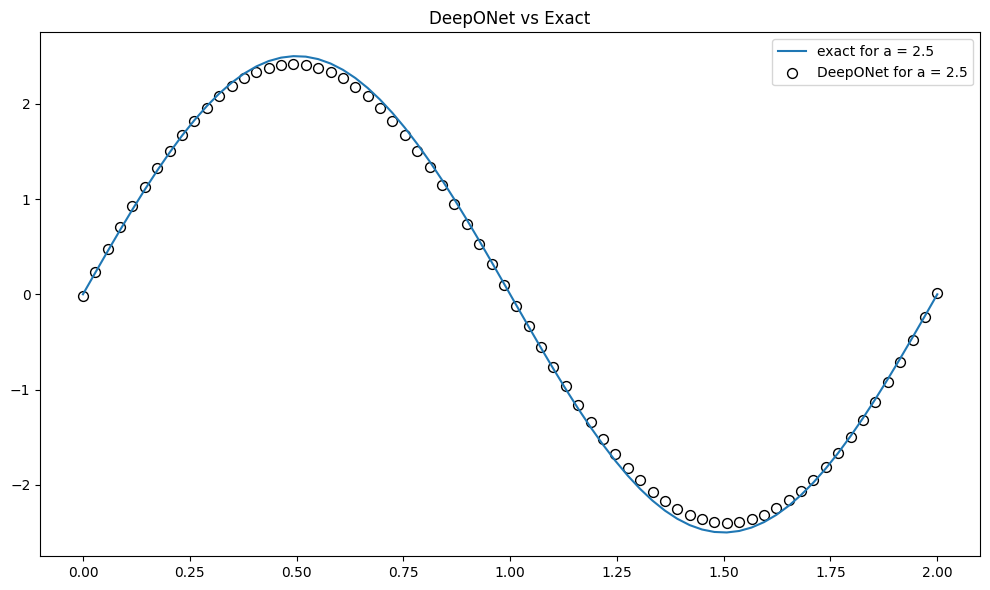

In [16]:
plt.figure(figsize=(10, 6))

plt.title("DeepONet vs Exact")
plt.plot(x_grid, u0_test[0], label = f"exact for a = {a_test[0,0]}")
plt.scatter(x_grid, u_hat[0], marker='o', s=50,color = 'white', edgecolors = 'black',label = f"DeepONet for a = {a_test[0,0]}")

plt.legend()
plt.tight_layout()
plt.show()

### Energy Dissipative Evolutionary DeepONet

We define the energy functional and other important functions for the problem. Since we are solving the 1D Heat equation, the energy is given as:
\begin{equation}
    E(u) = \int_0^2 \frac{1}{2}|u_x|^2 dx
\end{equation}
Things we are going to need:
* Functions evaluating the operator $\mathcal{N}(u)$, the energy $E(u)$, the modified energy $r^n$ and the tolerance $\xi^{n+1}$.
* The Jacobians $J_1$ and $J_2$.
* $\gamma_1^{opt}$, $\gamma_2^{opt}$.
* Forward Euler: \begin{equation} W^{n+1} = W^{n} + \gamma^{opt} \Delta t. \end{equation}
* Finally, an update for $u(x,t)$: \begin{equation} u(x,t^{n+1}) = \sum_k^p b_k(W_1^{n+1}) g_k(W_2^{n+1}). \end{equation}

In [17]:
class EDEDeepONetSolver:
    def __init__(self, model, cfg, device):
        self.model = model
        self.cfg = cfg
        self.device = device

        self.b_params = dict(model.branch.named_parameters()) #Branch parameters
        self.b_param_shapes = [p.shape for p in self.b_params.values()] #Shape of all branch parameters
        self.b_param_names = list(self.b_params.keys()) #Names of all branch parameters

        self.t_params = dict(model.trunk.named_parameters()) #Trunk parameters
        self.t_param_shapes = [p.shape for p in self.t_params.values()] #Shape of all Trunk parameters
        self.t_param_names = list(self.t_params.keys()) #Names of all Trunk parameters

        self.W1 = parameters_to_vector(self.b_params.values()).detach().clone().requires_grad_(True)
        self.W2 = parameters_to_vector(self.t_params.values()).detach().clone().requires_grad_(True)


    #Replace parameters with updated parameters. This is essential for computing the Jacobian
    def vector_to_named_parameters(self,w, p_names, p_shapes):
      sizes = [torch.tensor(s).prod().item() for s in p_shapes] #Total number of elements in each branch/trunk parameter (weight or bias)
      splits = torch.split(w, sizes) #Splits the flat vector of parameters into chunks according to the number of elements in each parameters
      #Reshapes each chunk into the model parameters and returns an ordered dictionary
      return OrderedDict(
          (name, param.view(shape))
          for name, shape, param in zip(p_names, p_shapes, splits)
      )

    def set_params(self, w1, w2): #Updates the parameters of the model
      vector_to_parameters(w1, self.model.branch.parameters())
      vector_to_parameters(w2, self.model.trunk.parameters())

    def compute_u(self, a_grid, x_grid=None):
      self.set_params(self.W1, self.W2)
      if x_grid is None:
          x_grid = self.cfg.x_grid.to(self.device)
      B_out = self.model.branch(a_grid.to(self.device))
      T_out = self.model.trunk(x_grid)
      return B_out @ T_out.T

    def dfx(self, f, x):
      return grad(f, x, grad_outputs=torch.ones_like(f), create_graph=True)[0]

    def Nu_energy(self, a_grid, x = None):
      u_x = []; u_xx = []
      if x is None:
        x = self.cfg.x_grid.clone().detach().to(self.device).requires_grad_(True)
      #self.set_params(self.W1, self.W2) #Update parameter t
      B_out = self.model.branch(a_grid.to(self.device))
      #def u_func(x): return B_out @ self.model.trunk(x).T
      u = self.compute_u(a_grid, x)
      for i in range(u.shape[0]):
        u_x_i = self.dfx(u[i].view(-1,1), x)
        u_xx_i = self.dfx(u_x_i, x)
        u_x.append(u_x_i)
        u_xx.append(u_xx_i)
      u_x = torch.cat(u_x, dim = 0)
      Nu = torch.cat(u_xx, dim = 0).view(-1)
      integrand = 0.5 * u_x.abs() ** 2
      energy = torch.tensor(torch.trapz(integrand, x, dim = 0).item())
      return Nu, energy

    def modified_energy(self,nu, enr, r_prev, dt):
        N_norm = torch.linalg.vector_norm(nu) ** 2
        return r_prev / (1 + 0.5 * dt * N_norm / enr)

    def update_params_euler(self, gamma1, gamma2, dt):
        self.W1 = self.W1 + dt * gamma1
        self.W2 = self.W2 + dt * gamma2
        self.set_params(self.W1, self.W2)
        return self.W1, self.W2

    def jacobians(self, a_grid, B_out=None, T_out=None, x = None):
      if x is None:
        x = self.cfg.x_grid.clone().detach().to(self.device).requires_grad_(True)
      def branch_out(w):
        named_param_dict = self.vector_to_named_parameters(w, self.b_param_names, self.b_param_shapes)
        out = functional_call(model.branch, named_param_dict, (a_grid,))
        return (out @ T_out.T).view(-1)

      def trunk_out(w):
        named_param_dict = self.vector_to_named_parameters(w, self.t_param_names, self.t_param_shapes)
        out = functional_call(model.trunk, named_param_dict, (x,))
        return (B_out @ out.T).view(-1)


        #self.set_params(self.W1, self.W2)  # ensure current weights are restored

      if B_out is None:
          B_out = self.model.branch(a_grid)
      if T_out is None:
          T_out = self.model.trunk(self.cfg.x_grid.to(self.device))
      J1 = jacobian(branch_out, self.W1)
      J2 = jacobian(trunk_out, self.W2)
      return J1, J2

    def lin_sys_solver(self, j1,j2, xi, nu):
      A11 = j1.T @ j1 ;A12 = j1.T @ j2
      A21 = j2.T @ j1 ; A22 = j2.T @ j2

      b1 = -j1.T @ (xi *nu); b2 = -j2.T @ (xi*nu)
      #Concatenating into a block
      A = torch.cat([torch.cat([A11, A12], dim=1), torch.cat([A21, A22], dim=1)], dim=0).to(self.device)
      b = torch.cat([b1, b2], dim=0).to(device)
      #Solve the linear system
      A_inv = torch.linalg.pinv(A)
      gamma_pinv = A_inv @ b
      gamma1 = gamma_pinv[:A11.shape[0]]
      gamma2 = gamma_pinv[A11.shape[0]:]
      return gamma1, gamma2

    def update_cond(self,rnew, energy_prev):
      return rnew / energy_prev


    #def residual(self, a_grid):
    #    u = self.compute_u(a_grid)
    #    Nu_val, u_val, x = self.Nu(a_grid)
    #    E = self.energy(u_val, x)
    #    return u, Nu_val, E


In [20]:
solver = EDEDeepONetSolver(model, cfg, device)

In [21]:
data = cfg.a_grid.to(device)
print(data.shape)
dt = 0.1

torch.Size([70, 1])


In [22]:
Nu, E = solver.Nu_energy(data)
print(Nu.shape, E)

RuntimeError: The size of tensor a (3499) must match the size of tensor b (49) at non-singleton dimension 0

In [34]:
u0 = solver.compute_u(data)
print(u0.shape)

torch.Size([1, 50])


In [35]:
#Obtaining the modified Energy
r0 = torch.sqrt(E)
print(r0)
r1 = solver.modified_energy(Nu, E, r0, dt)
print(r1)
xi = solver.update_cond(r1, r0)
print(xi)


tensor(3.1723)
tensor(2.5379, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8000, device='cuda:0', grad_fn=<DivBackward0>)


In [80]:
#Algorithm for EDE-DeepONet, using the restart strategy
tol = 2*10e-2;
#Compute u^(1)
#To compute u1, we need to solve for the updated weights
J1, J2 = solver.jacobians(data1)
gamma1, gamma2 = solver.lin_sys_solver(J1,J2, xi, Nu)
W1_news, W2_news = solver.update_params_euler(gamma1, gamma2, dt)
u1 = solver.compute_u(data1)
Nu1, E1 = solver.Nu_energy(data1)
rnew = solver.modified_energy(Nu1, E1, r1, dt)
print("modified energy is now:", rnew)
xi = solver.update_cond(rnew, r0)
print("xi is now:", xi)
print('Difference between previous and now is:',torch.norm(u0-u1).item())



#if (1 - xi) > tol:
#  Nu1, E1 = solver.Nu_energy(data1)
#  rnew = solver.modified_energy(Nu1, E1, r1, dt)
#  xi = solver.update_cond(rnew, r0)
#  xi =

modified energy is now: tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)
xi is now: tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
Difference between previous and now is: 0.27539995312690735


In [87]:
def exact(x,t, a):
  u = a * torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * torch.tensor(t))
  return u

u1_exact = exact(cfg.x_grid, dt, data1.item())
u1_exact.shape

torch.Size([50, 1])

In [94]:
torch.linalg.norm(u1_exact.view(-1) - u1.detach().cpu().view(-1))

tensor(4.6309)

In [95]:
u1 = u1.detach().cpu()

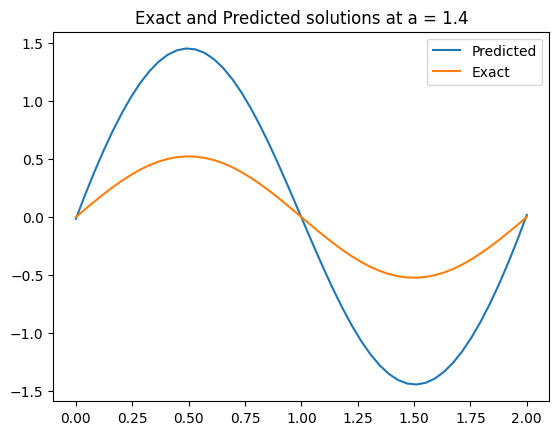

In [100]:
#Visualizing
plt.title(f"Exact and Predicted solutions at a = {cfg.a_grid[0].item():.2}")
plt.plot(cfg.x_grid.squeeze(1), u1.view(-1), label = f"Predicted")
plt.plot(cfg.x_grid.squeeze(1), u1_exact.view(-1), label = f"Exact")
plt.legend()
plt.show()

In [36]:
J1, J2 = solver.jacobians(data1)
print(J1.shape, J2.shape)

torch.Size([50, 1610]) torch.Size([50, 680])


In [37]:
J2

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -5.2234,  1.0544, -0.9904],
        [-0.1253, -0.0570,  0.0502,  ..., -5.2234,  1.0544, -0.9904],
        [-0.2728, -0.1163,  0.1008,  ..., -5.2234,  1.0544, -0.9904],
        ...,
        [-6.1056, -4.4288,  2.6895,  ..., -5.2234,  1.0544, -0.9904],
        [-5.7229, -4.5271,  2.7536,  ..., -5.2234,  1.0544, -0.9904],
        [-5.3535, -4.6233,  2.8180,  ..., -5.2234,  1.0544, -0.9904]],
       device='cuda:0')

In [38]:
xi

tensor(0.8000, device='cuda:0', grad_fn=<DivBackward0>)

In [39]:
A11 = J1.T @ J1     # (p1, p1)
A12 = J1.T @ J2     # (p1, p2)
A21 = J2.T @ J1     # (p2, p1)
A22 = J2.T @ J2     # (p2, p2)

b1 = -J1.T @ (xi *Nu)      # (p1,)
b2 = -J2.T @ (xi*Nu)      # (p2,)

print(f"Shape of A11: {A11.shape}")
print(f"Shape of A12: {A12.shape}")
print(f"Shape of A21: {A21.shape}")
print(f"Shape of A22: {A22.shape}")
print(f"Shape of b1: {b1.shape}")
print(f"Shape of b2: {b2.shape}")

Shape of A11: torch.Size([1610, 1610])
Shape of A12: torch.Size([1610, 680])
Shape of A21: torch.Size([680, 1610])
Shape of A22: torch.Size([680, 680])
Shape of b1: torch.Size([1610])
Shape of b2: torch.Size([680])


In [40]:
# Assemble A and b
A_top = torch.cat([A11, A12], dim=1)
A_bot = torch.cat([A21, A22], dim=1)
A = torch.cat([A_top, A_bot], dim=0).to(device)

b = torch.cat([b1, b2], dim=0).to(device)


In [41]:
U, S, Vh = torch.linalg.svd(A)
print("SVD min/max singular values:", S.min().item(), S.max().item())
print("Condition number:", (S.max() / S.min()).item())

SVD min/max singular values: 8.064958985744882e-15 33783.9765625
Condition number: 4.188983171175416e+18


In [30]:
rank = torch.linalg.matrix_rank(A)
print(f"Matrix rank: {rank}, expected: {A.shape[0]}")

Matrix rank: 4, expected: 2290


In [31]:
W1 = parameters_to_vector(model.branch.parameters()).detach().clone().requires_grad_(True)
W2 = parameters_to_vector(model.trunk.parameters()).detach().clone().requires_grad_(True)

In [37]:
#Obtaining solution through least-square
solution = torch.linalg.lstsq(A, b)
gamma_lstsq = solution.solution
gamma1_lstsq = gamma_lstsq[:A11.shape[0]]
gamma2_lstsq = gamma_lstsq[A11.shape[0]:]

print(f"Shape of gamma1: {gamma1_lstsq.shape}")
print(f"Shape of gamma2: {gamma2_lstsq.shape}")

#Analysis
print(f"Norm of gamma: {torch.linalg.norm(gamma_lstsq)}")
residual = A @ gamma_lstsq - b
print(f"Norm of residual: {torch.linalg.norm(residual)}")

Shape of gamma1: torch.Size([1610])
Shape of gamma2: torch.Size([680])
Norm of gamma: 35637.08203125
Norm of residual: 0.024296095594763756


In [38]:
#Obtaining solution using Pseudoinverse
A_inv = torch.linalg.pinv(A)
solution_pinv = A_inv @ b
gamma_pinv = solution_pinv
gamma1_pinv = gamma_pinv[:A11.shape[0]]
gamma2_pinv = gamma_pinv[A11.shape[0]:]

#Analysis
print(f"Norm of gamma: {torch.linalg.norm(gamma_pinv)}")
residual = A @ gamma_pinv - b
print(f"Norm of residual: {torch.linalg.norm(residual)}")

Norm of gamma: 0.1451273411512375
Norm of residual: 0.07154814898967743


In [53]:
W1_new = W1 + dt * gamma1_pinv.view(-1)
W2_new = W2 + dt * gamma2_pinv.view(-1)

In [54]:
(W1_new - W1_news).abs().max()

tensor(2776.4080, device='cuda:0', grad_fn=<MaxBackward1>)

In [56]:
(W2_new - W2_news).abs().max()

tensor(84.1881, device='cuda:0', grad_fn=<MaxBackward1>)